In [1]:
import pandas as pd
from obp.dataset import OpenBanditDataset
import os
import plotly.express as px
import numpy as np
import string
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Import visualization functions from our custom module
from visualizations import plot_bar_chart, plot_distribution_with_cdf

print(os.getcwd())

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/armandoordoricadelatorre/Documents/U of T/PhD/PhD Research/OBP_Replication


### Helper functions

In [2]:

def remap_user_features(df, feature_cols):
    """
    Map hash values in user_feature_N to short readable codes like A1, B1, ...
    """
    df_copy = df.copy()
    mapping_dicts = {}

    for col in feature_cols:
        # Extract the feature index (N from 'user_feature_N')
        feature_idx = col.split("_")[-1]
        uniques = df[col].dropna().unique()

        # Build codes A{N}, B{N}, C{N}...
        codes = [f"{letter}{feature_idx}" for letter in string.ascii_uppercase[:len(uniques)]]
        mapping = dict(zip(uniques, codes))

        df_copy[col] = df[col].map(mapping)
        mapping_dicts[col] = mapping

    return df_copy, mapping_dicts

### Import logged data from `all.csv` and `item_context.csv`

In [3]:

# BTS / ALL sample
log_df   = pd.read_csv("zr-obp/obd/bts/all/all.csv", index_col=0)
items_df = pd.read_csv("zr-obp/obd/bts/all/item_context.csv", index_col=0)

print("log_df shape:", log_df.shape)
print("items_df shape:", items_df.shape)

print("\nlog_df columns:")
print(log_df.columns.tolist()[:40])  # peek first ~40 col names

print("\nfirst 5 log rows:")
print(log_df.head())

print("\nfirst 5 item rows:")
print(items_df.head())

log_df shape: (10000, 89)
items_df shape: (80, 5)

log_df columns:
['timestamp', 'item_id', 'position', 'click', 'propensity_score', 'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3', 'user-item_affinity_0', 'user-item_affinity_1', 'user-item_affinity_2', 'user-item_affinity_3', 'user-item_affinity_4', 'user-item_affinity_5', 'user-item_affinity_6', 'user-item_affinity_7', 'user-item_affinity_8', 'user-item_affinity_9', 'user-item_affinity_10', 'user-item_affinity_11', 'user-item_affinity_12', 'user-item_affinity_13', 'user-item_affinity_14', 'user-item_affinity_15', 'user-item_affinity_16', 'user-item_affinity_17', 'user-item_affinity_18', 'user-item_affinity_19', 'user-item_affinity_20', 'user-item_affinity_21', 'user-item_affinity_22', 'user-item_affinity_23', 'user-item_affinity_24', 'user-item_affinity_25', 'user-item_affinity_26', 'user-item_affinity_27', 'user-item_affinity_28', 'user-item_affinity_29', 'user-item_affinity_30']

first 5 log rows:
           

/var/folders/y5/tznhkgh5213_vwg51thdy0x80000gn/T/ipykernel_13061/924298069.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(items_df['item_feature_0'])


<Axes: xlabel='item_feature_0', ylabel='Density'>

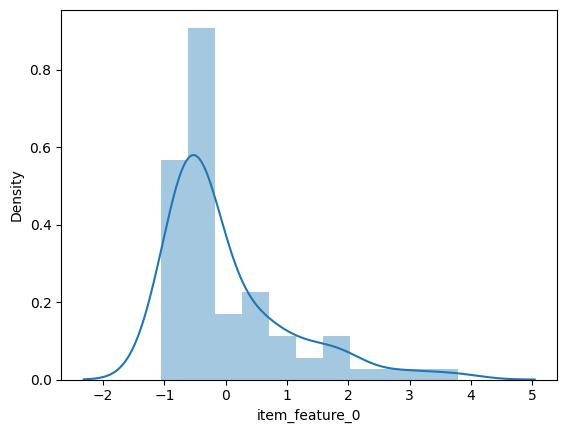

In [4]:
import seaborn as sns
sns.distplot(items_df['item_feature_0'])

In [5]:
items_df['item_feature_0'].min(), items_df['item_feature_0'].max(), items_df['item_feature_0'].nunique()

(-1.056718399349641, 3.782787592501191, 41)

In [6]:
log_df['propensity_score'].min(), log_df['propensity_score'].max(), log_df['propensity_score'].nunique()

(4.5e-05, 0.95424, 7883)

In [7]:
for user_features in log_df.columns.tolist():
    if user_features.startswith("user_feature_"):
        print(f"{user_features}: min={log_df[user_features].min()}, max={log_df[user_features].max()}, unique={log_df[user_features].nunique()}")

user_feature_0: min=4ae385d792f81dde128124a925a830de, max=cef3390ed299c09874189c387777674a, unique=3
user_feature_1: min=03a5648a76832f83c859d46bc06cb64a, max=f1c2d6a32ec39249160cf784b63f4c6f, unique=5
user_feature_2: min=2723d2eb8bba04e0362098011fa3997b, max=c7cce49040b6630e9b5484dfcc0e6cd1, unique=9
user_feature_3: min=05b76f5e97e51128862059ac7df9e42a, max=f97571b9c14a786aab269f0b427d2a85, unique=9


In [8]:
log_df['user-item_affinity_0'].min(), log_df['user-item_affinity_0'].max(), log_df['user-item_affinity_0'].nunique()

(0.0, 0.0, 1)

In [9]:
for item_feature in items_df.columns.tolist():
    if item_feature.startswith("item_feature_"):
        print(f"{item_feature}: min={items_df[item_feature].min()}, max={items_df[item_feature].max()}, unique={items_df[item_feature].nunique()}")

item_feature_0: min=-1.056718399349641, max=3.782787592501191, unique=41
item_feature_1: min=1c3ca9815f059a8c26c6d1fae6071105, max=fd5c8b8aa48f0f39108b280da9c3bb99, unique=12
item_feature_2: min=02f313f24a15548a9d0c2948d584f370, max=e338631de2b9905f20cc62bd7764ce49, unique=21
item_feature_3: min=36163e60414fb83e275f7a3cff00ccbc, max=ee93c727c612367ffb4d9881f8948d68, unique=7


### Remapping categorical features to readable categories

In [10]:
user_feature_cols = [c for c in log_df.columns if c.startswith("user_feature")]
log_df_readable, mappings = remap_user_features(log_df, user_feature_cols)

print("Sample remapped features:")
display(log_df_readable[user_feature_cols].head())

print("\nMappings used:")
for feat, mapping in mappings.items():
    print(f"{feat}: {mapping}")

Sample remapped features:


,user_feature_0,user_feature_1,user_feature_2,user_feature_3
0,A0,A1,A2,A3
1,A0,B1,B2,B3
2,A0,A1,C2,A3
3,A0,A1,A2,B3
4,A0,A1,C2,B3



Mappings used:
user_feature_0: {'81ce123cbb5bd8ce818f60fb3586bba5': 'A0', 'cef3390ed299c09874189c387777674a': 'B0', '4ae385d792f81dde128124a925a830de': 'C0'}
user_feature_1: {'03a5648a76832f83c859d46bc06cb64a': 'A1', '2d03db5543b14483e52d761760686b64': 'B1', '6ff54aa8ff7a9dde75161c20a3ee4231': 'C1', 'f1c2d6a32ec39249160cf784b63f4c6f': 'D1', '8b50621825ffd909dd8d8317d366271f': 'E1'}
user_feature_2: {'7bc94a2da491829b777c49c4b5e480f2': 'A2', '2723d2eb8bba04e0362098011fa3997b': 'B2', 'c2e4f76cdbabecd33b8c762aeef386b3': 'C2', '719dab53a7560218a9d1f96b25d6fa32': 'D2', '9b2d331c329ceb74d3dcfb48d8798c78': 'E2', '302deff13f835d731df1c842eed95971': 'F2', '9f4e8271d3d3014af5f35124c2de5082': 'G2', '7ae37150e596e6e8f19e27a06bd4d359': 'H2', 'c7cce49040b6630e9b5484dfcc0e6cd1': 'I2'}
user_feature_3: {'c39b0c7dd5d4eb9a18e7db6ba2f258f8': 'A3', '9bde591ffaab8d54c457448e4dca6f53': 'B3', '05b76f5e97e51128862059ac7df9e42a': 'C3', 'f97571b9c14a786aab269f0b427d2a85': 'D3', '06128286bcc64b6a4b0fb7bc0328fe17'

In [11]:
log_df_readable.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,user-item_affinity_10,user-item_affinity_11,user-item_affinity_12,user-item_affinity_13,user-item_affinity_14,user-item_affinity_15,user-item_affinity_16,user-item_affinity_17,user-item_affinity_18,user-item_affinity_19,user-item_affinity_20,user-item_affinity_21,user-item_affinity_22,user-item_affinity_23,user-item_affinity_24,user-item_affinity_25,user-item_affinity_26,user-item_affinity_27,user-item_affinity_28,user-item_affinity_29,user-item_affinity_30,user-item_affinity_31,user-item_affinity_32,user-item_affinity_33,user-item_affinity_34,user-item_affinity_35,user-item_affinity_36,user-item_affinity_37,user-item_affinity_38,user-item_affinity_39,user-item_affinity_40,user-item_affinity_41,user-item_affinity_42,user-item_affinity_43,user-item_affinity_44,user-item_affinity_45,user-item_affinity_46,user-item_affinity_47,user-item_affinity_48,user-item_affinity_49,user-item_affinity_50,user-item_affinity_51,user-item_affinity_52,user-item_affinity_53,user-item_affinity_54,user-item_affinity_55,user-item_affinity_56,user-item_affinity_57,user-item_affinity_58,user-item_affinity_59,user-item_affinity_60,user-item_affinity_61,user-item_affinity_62,user-item_affinity_63,user-item_affinity_64,user-item_affinity_65,user-item_affinity_66,user-item_affinity_67,user-item_affinity_68,user-item_affinity_69,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:17.004101+00:00,79,2,0,0.087125,A0,A1,A2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:19.715857+00:00,14,1,0,0.006235,A0,B1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:01:04.303227+00:00,18,2,0,0.061300,A0,A1,C2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:01:11.571162+00:00,28,1,0,0.019430,A0,A1,A2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:02:41.811768+00:00,65,2,0,0.019375,A0,A1,C2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Importing from Random instead of BTS

In [12]:

# Random / ALL sample
random_log_df   = pd.read_csv("zr-obp/obd/random/all/all.csv", index_col=0)
random_items_df = pd.read_csv("zr-obp/obd/random/all/item_context.csv", index_col=0)

print("log_df shape:", random_log_df.shape)
print("items_df shape:", random_items_df.shape)

print("\nlog_df columns:")
print(random_log_df.columns.tolist()[:40])  # peek first ~40 col names

print("\nfirst 5 log rows:")
print(random_log_df.head())

print("\nfirst 5 item rows:")
print(random_items_df.head())

log_df shape: (10000, 89)
items_df shape: (80, 5)

log_df columns:
['timestamp', 'item_id', 'position', 'click', 'propensity_score', 'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3', 'user-item_affinity_0', 'user-item_affinity_1', 'user-item_affinity_2', 'user-item_affinity_3', 'user-item_affinity_4', 'user-item_affinity_5', 'user-item_affinity_6', 'user-item_affinity_7', 'user-item_affinity_8', 'user-item_affinity_9', 'user-item_affinity_10', 'user-item_affinity_11', 'user-item_affinity_12', 'user-item_affinity_13', 'user-item_affinity_14', 'user-item_affinity_15', 'user-item_affinity_16', 'user-item_affinity_17', 'user-item_affinity_18', 'user-item_affinity_19', 'user-item_affinity_20', 'user-item_affinity_21', 'user-item_affinity_22', 'user-item_affinity_23', 'user-item_affinity_24', 'user-item_affinity_25', 'user-item_affinity_26', 'user-item_affinity_27', 'user-item_affinity_28', 'user-item_affinity_29', 'user-item_affinity_30']

first 5 log rows:
           

In [26]:
# def generate_schema_table(df, table_name="DataFrame", max_unique_display=10, sample_size=5):
#     """
#     Generate a schema table showing column names, possible values, and cardinality.
    
#     Parameters:
#     - df: pandas DataFrame to analyze
#     - table_name: name of the table for display
#     - max_unique_display: maximum number of unique values to display explicitly
#     - sample_size: number of sample values to show when there are too many unique values
    
#     Returns:
#     - pandas DataFrame with schema information
#     """
#     schema_data = []
    
#     for col in df.columns:
#         series = df[col]
        
#         # Get basic stats
#         unique_values = series.dropna().unique()
#         cardinality = len(unique_values)
        
#         # Determine how to display possible values
#         if cardinality == 0:
#             possible_values = "No data"
#         elif cardinality <= max_unique_display:
#             # Show all unique values
#             if series.dtype in ['object', 'category']:
#                 # For categorical/string data
#                 values_str = '{' + ', '.join([f"'{v}'" if isinstance(v, str) else str(v) for v in sorted(unique_values)[:sample_size]]) + '}'
#             else:
#                 # For numeric data
#                 values_str = '{' + ', '.join([str(v) for v in sorted(unique_values)]) + '}'
#         else:
#             # Too many unique values, show range or sample
#             if pd.api.types.is_numeric_dtype(series):
#                 # For numeric columns, show range
#                 min_val = series.min()
#                 max_val = series.max()
#                 values_str = f"{{{min_val}, ...{max_val}}}"
#             else:
#                 # For categorical columns, show sample
#                 sample_values = sorted(unique_values)[:sample_size]
#                 values_str = '{' + ', '.join([f"'{v}'" if isinstance(v, str) else str(v) for v in sample_values]) + ', ...}'
        
#         # Determine data type annotation
#         dtype_annotation = ""
#         if pd.api.types.is_integer_dtype(series):
#             dtype_annotation = " (int)"
#         elif pd.api.types.is_float_dtype(series):
#             dtype_annotation = " (float)"
#         elif pd.api.types.is_datetime64_any_dtype(series):
#             dtype_annotation = " (datetime)"
        
#         # Handle special cases for specific column patterns
#         if col.startswith('user-item_affinity_'):
#             # Group affinity columns
#             affinity_cols = [c for c in df.columns if c.startswith('user-item_affinity_')]
#             if col == affinity_cols[0]:  # Only add once for the first affinity column
#                 col_name = f"user-item_affinity_{{0,1,..{len(affinity_cols)-1}}}"
#                 # Check the range of values across all affinity columns
#                 all_affinity_values = pd.concat([df[c] for c in affinity_cols]).dropna().unique()
#                 cardinality = "varies"
#                 min_val = pd.concat([df[c] for c in affinity_cols]).min()
#                 max_val = pd.concat([df[c] for c in affinity_cols]).max()
#                 possible_values = f"{{{min_val}, {max_val}}}"
#             else:
#                 continue  # Skip other affinity columns as they're grouped
#         else:
#             col_name = col + dtype_annotation
        
#         schema_data.append({
#             'Column Name': col_name,
#             'Possible values': possible_values,
#             '|S|': cardinality
#         })
    
#     schema_df = pd.DataFrame(schema_data)
    
#     print(f"\n=== {table_name} Schema ===")
#     print(schema_df.to_string(index=False))
    
#     return schema_df

In [27]:
# # Generate schema tables for the random dataset
# log_schema = generate_schema_table(random_log_df, "all.csv (Random Policy)")
# items_schema = generate_schema_table(random_items_df, "item_context.csv")

In [28]:
# log_schema

In [44]:
def generate_detailed_schema_table(df, table_name="DataFrame"):
    """
    Generate a detailed schema table that matches the format from the examples.
    Handles special cases like user-item affinity columns and provides appropriate formatting.
    """
    schema_data = []
    processed_affinity = False
    
    for col in df.columns:
        series = df[col].dropna()
        
        # Skip if already processed affinity columns
        if col.startswith('user-item_affinity_') and processed_affinity:
            continue
            
        if col.startswith('user-item_affinity_') and not processed_affinity:
            # Handle user-item affinity columns as a group
            affinity_cols = [c for c in df.columns if c.startswith('user-item_affinity_')]
            # Extract numbers from column names to get the range
            affinity_numbers = []
            for acol in affinity_cols:
                try:
                    num = int(acol.split('_')[-1])
                    affinity_numbers.append(num)
                except:
                    pass
            
            if affinity_numbers:
                min_idx = min(affinity_numbers)
                max_idx = max(affinity_numbers)
                col_name = f"user-item_affinity_{{{min_idx},{min_idx+1},..{max_idx}}}"
            else:
                col_name = "user-item_affinity_*"
            
            # Get unique values across all affinity columns
            all_affinity_values = set()
            for acol in affinity_cols:
                all_affinity_values.update(df[acol].dropna().unique())
            
            if len(all_affinity_values) <= 10:
                possible_values = '{' + ', '.join(map(str, sorted(all_affinity_values))) + '}'
            else:
                min_val = min(all_affinity_values)
                max_val = max(all_affinity_values)
                possible_values = f"{{{min_val}, {max_val}}}"
            
            cardinality = "varies"
            processed_affinity = True
            
        else:
            # Handle regular columns
            col_name = col
            unique_values = series.unique()
            cardinality = len(unique_values)
            
            # Add type annotation for numeric columns
            if pd.api.types.is_integer_dtype(series):
                col_name += " (int)"
            elif pd.api.types.is_float_dtype(series):
                col_name += " (float)"
            
            # Format possible values based on data type and cardinality
            if cardinality == 0:
                possible_values = "No data"
            elif cardinality <= 10 and not pd.api.types.is_float_dtype(series):
                # Show all values for small cardinality non-float columns
                if pd.api.types.is_datetime64_any_dtype(series):
                    # For datetime, show range
                    min_val = series.min()
                    max_val = series.max()
                    possible_values = f"{{'{min_val}',... '{max_val}'}}"
                else:
                    sorted_values = sorted(unique_values)
                    if isinstance(sorted_values[0], str):
                        possible_values = '{' + ', '.join([f"'{v}'" for v in sorted_values]) + '}'
                    else:
                        possible_values = '{' + ', '.join(map(str, sorted_values)) + '}'
            else:
                # Show range for high cardinality or float columns
                if pd.api.types.is_numeric_dtype(series):
                    min_val = series.min()
                    max_val = series.max()
                    possible_values = f"{{{min_val}, {max_val}}}"
                elif pd.api.types.is_datetime64_any_dtype(series):
                    min_val = series.min()
                    max_val = series.max()
                    possible_values = f"{{'{min_val}',... '{max_val}'}}"
                else:
                    # For categorical with many values, show it's categorical hashes or similar
                    if 'feature' in col.lower():
                        possible_values = "categorical hashes"
                    else:
                        sample_values = sorted(unique_values)[:3]
                        if isinstance(sample_values[0], str):
                            possible_values = '{' + ', '.join([f"'{v}'" for v in sample_values]) + ', ...}'
                        else:
                            possible_values = '{' + ', '.join(map(str, sample_values)) + ', ...}'
        
        schema_data.append({
            'Column Name': col_name,
            'Possible values': possible_values,
            '|S|': cardinality
        })
    
    schema_df = pd.DataFrame(schema_data)
    
    print(f"\n=== {table_name} Schema ===")
    print(schema_df.to_string(index=False))
    print()
    
    return schema_df

In [31]:
# Generate detailed schema tables that match the format from your examples
log_detailed_schema = generate_detailed_schema_table(random_log_df, "all.csv (Random Policy)")
display(log_detailed_schema)
items_detailed_schema = generate_detailed_schema_table(random_items_df, "item_context.csv")
display(items_detailed_schema)


=== all.csv (Random Policy) Schema ===
                  Column Name                                                                                                                                                                                                                                                                                  Possible values    |S|
                    timestamp                                                                                                                                                                                {'2019-11-24 00:00:34.762830+00:00', '2019-11-24 00:00:53.965051+00:00', '2019-11-24 00:00:56.727734+00:00', ...}   9991
                item_id (int)                                                                                                                                                                                                                                                                                       

,Column Name,Possible values,|S|
0,timestamp,"{'2019-11-24 00:00:34.762830+00:00', '2019-11-...",9991
1,item_id (int),"{0, 79}",80
2,position (int),"{1, 2, 3}",3
3,click (int),"{0, 1}",2
4,propensity_score (float),"{0.0125, 0.0125}",1
5,user_feature_0,"{'4ae385d792f81dde128124a925a830de', '81ce123c...",3
6,user_feature_1,"{'03a5648a76832f83c859d46bc06cb64a', '2d03db55...",5
7,user_feature_2,"{'2723d2eb8bba04e0362098011fa3997b', '302deff1...",8
8,user_feature_3,"{'05b76f5e97e51128862059ac7df9e42a', '06128286...",8
9,"user-item_affinity_{0,1,..79}","{0.0, 1.0, 2.0}",varies



=== item_context.csv Schema ===
           Column Name                                                                                                                                                                                                                                              Possible values  |S|
         item_id (int)                                                                                                                                                                                                                                                      {0, 79}   80
item_feature_0 (float)                                                                                                                                                                                                                      {-1.056718399349641, 3.782787592501191}   41
        item_feature_1                                                                                                      

,Column Name,Possible values,|S|
0,item_id (int),"{0, 79}",80
1,item_feature_0 (float),"{-1.056718399349641, 3.782787592501191}",41
2,item_feature_1,categorical hashes,12
3,item_feature_2,categorical hashes,21
4,item_feature_3,"{'1ced27f8748b9def6220f316c049381d', '1ead5eb1...",7


In [24]:
log_detailed_schema

,Column Name,Possible values,|S|
0,timestamp,"{'2019-11-24 00:00:34.762830+00:00', '2019-11-...",9991
1,item_id (int),"{0, 79}",80
2,position (int),"{1, 2, 3}",3
3,click (int),"{0, 1}",2
4,propensity_score (float),"{0.0125, 0.0125}",1
5,user_feature_0,"{'4ae385d792f81dde128124a925a830de', '81ce123c...",3
6,user_feature_1,"{'03a5648a76832f83c859d46bc06cb64a', '2d03db55...",5
7,user_feature_2,"{'2723d2eb8bba04e0362098011fa3997b', '302deff1...",8
8,user_feature_3,"{'05b76f5e97e51128862059ac7df9e42a', '06128286...",8
9,"user-item_affinity_{0,1,..79}","{0.0, 1.0, 2.0}",varies


In [25]:
items_detailed_schema

,Column Name,Possible values,|S|
0,item_id (int),"{0, 79}",80
1,item_feature_0 (float),"{-1.056718399349641, 3.782787592501191}",41
2,item_feature_1,categorical hashes,12
3,item_feature_2,categorical hashes,21
4,item_feature_3,"{'1ced27f8748b9def6220f316c049381d', '1ead5eb1...",7


In [ ]:
def analyze_csv_schemas(log_csv_path, items_csv_path, dataset_name="Dataset"):
    """
    Convenience function to analyze schemas of both log and item CSV files.
    
    Parameters:
    - log_csv_path: path to the log CSV file (e.g., "all.csv")
    - items_csv_path: path to the items CSV file (e.g., "item_context.csv") 
    - dataset_name: name for the dataset (e.g., "Random Policy", "BTS Policy")
    """
    
    # Load the data
    log_df = pd.read_csv(log_csv_path, index_col=0)
    items_df = pd.read_csv(items_csv_path, index_col=0)
    
    print(f"\n{'='*50}")
    print(f"SCHEMA ANALYSIS FOR {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # Generate schemas
    log_schema = generate_detailed_schema_table(log_df, f"all.csv ({dataset_name})")
    items_schema = generate_detailed_schema_table(items_df, f"item_context.csv ({dataset_name})")
    
    return log_schema, items_schema

# Example usage:
# random_log_schema, random_items_schema = analyze_csv_schemas(
#     "zr-obp/obd/random/all/all.csv", 
#     "zr-obp/obd/random/all/item_context.csv", 
#     "Random Policy"
# )

In [32]:
def compare_policy_schemas(policies, base_path="zr-obp/obd", subset="all"):
    """
    Compare schemas across different policies (e.g., 'random' vs 'bts').
    
    Parameters:
    - policies: list of policy names (e.g., ['random', 'bts'])
    - base_path: base path to the data directory
    - subset: subset to analyze (e.g., 'all', 'small')
    
    Returns:
    - Dictionary with schemas for each policy
    """
    
    all_schemas = {}
    
    print(f"\n{'='*60}")
    print(f"COMPARING SCHEMAS ACROSS POLICIES: {', '.join(policies).upper()}")
    print(f"{'='*60}")
    
    for policy in policies:
        log_path = f"{base_path}/{policy}/{subset}/all.csv"
        items_path = f"{base_path}/{policy}/{subset}/item_context.csv"
        
        print(f"\n{'-'*40}")
        print(f"ANALYZING {policy.upper()} POLICY")
        print(f"{'-'*40}")
        
        try:
            # Load the data
            log_df = pd.read_csv(log_path, index_col=0)
            items_df = pd.read_csv(items_path, index_col=0)
            
            print(f"✓ Loaded {policy} data:")
            print(f"  - Log shape: {log_df.shape}")
            print(f"  - Items shape: {items_df.shape}")
            
            # Generate schemas
            log_schema = generate_detailed_schema_table(log_df, f"all.csv ({policy.title()} Policy)")
            items_schema = generate_detailed_schema_table(items_df, f"item_context.csv ({policy.title()} Policy)")
            
            all_schemas[policy] = {
                'log_schema': log_schema,
                'items_schema': items_schema,
                'log_shape': log_df.shape,
                'items_shape': items_df.shape
            }
            
        except FileNotFoundError as e:
            print(f"✗ Error loading {policy} data: {e}")
            all_schemas[policy] = None
        except Exception as e:
            print(f"✗ Unexpected error with {policy}: {e}")
            all_schemas[policy] = None
    
    return all_schemas

def compare_schema_differences(schemas_dict, show_differences_only=True):
    """
    Compare and highlight differences between policy schemas.
    
    Parameters:
    - schemas_dict: Dictionary returned by compare_policy_schemas
    - show_differences_only: If True, only show columns that differ between policies
    """
    
    policies = [p for p in schemas_dict.keys() if schemas_dict[p] is not None]
    
    if len(policies) < 2:
        print("Need at least 2 valid policies to compare")
        return
    
    print(f"\n{'='*60}")
    print(f"SCHEMA DIFFERENCES ANALYSIS")
    print(f"{'='*60}")
    
    # Compare log schemas
    print(f"\n📊 LOG SCHEMAS COMPARISON:")
    print(f"{'-'*30}")
    
    log_schemas = {p: schemas_dict[p]['log_schema'] for p in policies}
    
    # Get all unique columns across policies
    all_log_columns = set()
    for policy_schema in log_schemas.values():
        all_log_columns.update(policy_schema['Column Name'].tolist())
    
    differences_found = False
    for col in sorted(all_log_columns):
        col_info = {}
        for policy in policies:
            schema_df = log_schemas[policy]
            matching_rows = schema_df[schema_df['Column Name'] == col]
            if not matching_rows.empty:
                col_info[policy] = {
                    'values': matching_rows.iloc[0]['Possible values'],
                    'cardinality': matching_rows.iloc[0]['|S|']
                }
            else:
                col_info[policy] = {'values': 'MISSING', 'cardinality': 'MISSING'}
        
        # Check if there are differences
        values_set = set(info['values'] for info in col_info.values())
        cardinality_set = set(str(info['cardinality']) for info in col_info.values())
        
        has_difference = len(values_set) > 1 or len(cardinality_set) > 1
        
        if not show_differences_only or has_difference:
            if has_difference:
                differences_found = True
                print(f"\n⚠️  DIFFERENCE in '{col}':")
            else:
                print(f"\n✓ '{col}':")
            
            for policy in policies:
                info = col_info[policy]
                print(f"  {policy:>8}: |S|={info['cardinality']:>6} | {info['values']}")
    
    # Compare items schemas
    print(f"\n📦 ITEMS SCHEMAS COMPARISON:")
    print(f"{'-'*30}")
    
    items_schemas = {p: schemas_dict[p]['items_schema'] for p in policies}
    
    # Get all unique columns across policies
    all_items_columns = set()
    for policy_schema in items_schemas.values():
        all_items_columns.update(policy_schema['Column Name'].tolist())
    
    for col in sorted(all_items_columns):
        col_info = {}
        for policy in policies:
            schema_df = items_schemas[policy]
            matching_rows = schema_df[schema_df['Column Name'] == col]
            if not matching_rows.empty:
                col_info[policy] = {
                    'values': matching_rows.iloc[0]['Possible values'],
                    'cardinality': matching_rows.iloc[0]['|S|']
                }
            else:
                col_info[policy] = {'values': 'MISSING', 'cardinality': 'MISSING'}
        
        # Check if there are differences
        values_set = set(info['values'] for info in col_info.values())
        cardinality_set = set(str(info['cardinality']) for info in col_info.values())
        
        has_difference = len(values_set) > 1 or len(cardinality_set) > 1
        
        if not show_differences_only or has_difference:
            if has_difference:
                differences_found = True
                print(f"\n⚠️  DIFFERENCE in '{col}':")
            else:
                print(f"\n✓ '{col}':")
            
            for policy in policies:
                info = col_info[policy]
                print(f"  {policy:>8}: |S|={info['cardinality']:>6} | {info['values']}")
    
    if show_differences_only and not differences_found:
        print("\n✅ No schema differences found between policies!")
    
    return col_info

In [34]:
# Compare schemas between Random and BTS policies
policy_schemas = compare_policy_schemas(['random', 'bts'])

# Show detailed differences
differences = compare_schema_differences(policy_schemas, show_differences_only=True)


COMPARING SCHEMAS ACROSS POLICIES: RANDOM, BTS

----------------------------------------
ANALYZING RANDOM POLICY
----------------------------------------
✓ Loaded random data:
  - Log shape: (10000, 89)
  - Items shape: (80, 5)

=== all.csv (Random Policy) Schema ===
                  Column Name                                                                                                                                                                                                                                                                                  Possible values    |S|
                    timestamp                                                                                                                                                                                {'2019-11-24 00:00:34.762830+00:00', '2019-11-24 00:00:53.965051+00:00', '2019-11-24 00:00:56.727734+00:00', ...}   9991
                item_id (int)                                                  

In [ ]:
def compare_custom_schemas(dataset_configs):
    """
    Compare schemas from custom dataset configurations.
    
    Parameters:
    - dataset_configs: Dictionary with format:
      {
          'dataset_name': {
              'log_path': 'path/to/all.csv',
              'items_path': 'path/to/item_context.csv'
          }
      }
    
    Example:
    dataset_configs = {
        'Random Policy': {
            'log_path': 'zr-obp/obd/random/all/all.csv',
            'items_path': 'zr-obp/obd/random/all/item_context.csv'
        },
        'BTS Policy': {
            'log_path': 'zr-obp/obd/bts/all/all.csv', 
            'items_path': 'zr-obp/obd/bts/all/item_context.csv'
        }
    }
    """
    
    all_schemas = {}
    
    print(f"\n{'='*60}")
    print(f"COMPARING CUSTOM DATASET SCHEMAS")
    print(f"{'='*60}")
    
    for dataset_name, config in dataset_configs.items():
        print(f"\n{'-'*40}")
        print(f"ANALYZING {dataset_name.upper()}")
        print(f"{'-'*40}")
        
        try:
            # Load the data
            log_df = pd.read_csv(config['log_path'], index_col=0)
            items_df = pd.read_csv(config['items_path'], index_col=0)
            
            print(f"✓ Loaded {dataset_name} data:")
            print(f"  - Log path: {config['log_path']}")
            print(f"  - Log shape: {log_df.shape}")
            print(f"  - Items path: {config['items_path']}")
            print(f"  - Items shape: {items_df.shape}")
            
            # Generate schemas
            log_schema = generate_detailed_schema_table(log_df, f"all.csv ({dataset_name})")
            items_schema = generate_detailed_schema_table(items_df, f"item_context.csv ({dataset_name})")
            
            all_schemas[dataset_name] = {
                'log_schema': log_schema,
                'items_schema': items_schema,
                'log_shape': log_df.shape,
                'items_shape': items_df.shape
            }
            
        except FileNotFoundError as e:
            print(f"✗ Error loading {dataset_name} data: {e}")
            all_schemas[dataset_name] = None
        except Exception as e:
            print(f"✗ Unexpected error with {dataset_name}: {e}")
            all_schemas[dataset_name] = None
    
    return all_schemas

# Example usage with custom paths:
# dataset_configs = {
#     'Random Policy': {
#         'log_path': 'zr-obp/obd/random/all/all.csv',
#         'items_path': 'zr-obp/obd/random/all/item_context.csv'
#     },
#     'BTS Policy': {
#         'log_path': 'zr-obp/obd/bts/all/all.csv', 
#         'items_path': 'zr-obp/obd/bts/all/item_context.csv'
#     }
# }
# 
# custom_schemas = compare_custom_schemas(dataset_configs)
# differences = compare_schema_differences(custom_schemas, show_differences_only=True)

In [39]:
display(policy_schemas['random']['log_schema'])
display(policy_schemas['random']['items_schema'])



,Column Name,Possible values,|S|
0,timestamp,"{'2019-11-24 00:00:34.762830+00:00', '2019-11-...",9991
1,item_id (int),"{0, 79}",80
2,position (int),"{1, 2, 3}",3
3,click (int),"{0, 1}",2
4,propensity_score (float),"{0.0125, 0.0125}",1
5,user_feature_0,"{'4ae385d792f81dde128124a925a830de', '81ce123c...",3
6,user_feature_1,"{'03a5648a76832f83c859d46bc06cb64a', '2d03db55...",5
7,user_feature_2,"{'2723d2eb8bba04e0362098011fa3997b', '302deff1...",8
8,user_feature_3,"{'05b76f5e97e51128862059ac7df9e42a', '06128286...",8
9,"user-item_affinity_{0,1,..79}","{0.0, 1.0, 2.0}",varies


,Column Name,Possible values,|S|
0,item_id (int),"{0, 79}",80
1,item_feature_0 (float),"{-1.056718399349641, 3.782787592501191}",41
2,item_feature_1,categorical hashes,12
3,item_feature_2,categorical hashes,21
4,item_feature_3,"{'1ced27f8748b9def6220f316c049381d', '1ead5eb1...",7


In [43]:
display(policy_schemas['bts']['log_schema'])
display(policy_schemas['bts']['items_schema'])

,Column Name,Possible values,|S|
0,timestamp,"{'2019-11-24 00:00:17.004101+00:00', '2019-11-...",9999
1,item_id (int),"{0, 79}",80
2,position (int),"{1, 2, 3}",3
3,click (int),"{0, 1}",2
4,propensity_score (float),"{4.5e-05, 0.95424}",7883
5,user_feature_0,"{'4ae385d792f81dde128124a925a830de', '81ce123c...",3
6,user_feature_1,"{'03a5648a76832f83c859d46bc06cb64a', '2d03db55...",5
7,user_feature_2,"{'2723d2eb8bba04e0362098011fa3997b', '302deff1...",9
8,user_feature_3,"{'05b76f5e97e51128862059ac7df9e42a', '06128286...",9
9,"user-item_affinity_{0,1,..79}","{0.0, 1.0, 2.0, 3.0}",varies


,Column Name,Possible values,|S|
0,item_id (int),"{0, 79}",80
1,item_feature_0 (float),"{-1.056718399349641, 3.782787592501191}",41
2,item_feature_1,categorical hashes,12
3,item_feature_2,categorical hashes,21
4,item_feature_3,"{'36163e60414fb83e275f7a3cff00ccbc', '3c8f79ff...",7


In [ ]:
break 

{'values': '{0, 79}', 'cardinality': 80}

## EDA 

### Histogram on number of rows per day 

In [6]:
# Ensure proper datetime dtype (keeps timezone info)
log_df = log_df_readable.copy()
log_df['timestamp'] = pd.to_datetime(log_df['timestamp'], utc=True, errors='coerce')
log_df = log_df.loc[log_df['timestamp'].notna()]

# convert to your local timezone (example: Toronto)
log_df['timestamp'] = log_df['timestamp'].dt.tz_convert('America/Toronto')

# # Count rows per day, including days with zero rows
daily_counts = (
    log_df
    .set_index('timestamp')
    .resample('D')
    .size()
    .rename('rows')
    .reset_index()
)

# Use the plotting function
fig = plot_bar_chart(
    data=daily_counts,
    x_col='timestamp',
    y_col='rows',
    x_title='Date',
    y_title='Rows',
    title='Number of Rows per Day',
    height=500,
    show_values=True,
    value_format='{:,}'  # thousands separator
)

fig.show()


### Counting user features vs user-item features

In [7]:
user_feature_cols = [c for c in log_df_readable.columns if c.startswith('user_feature_')]
affinity_cols = [c for c in log_df_readable.columns if c.startswith('user-item_affinity_')]

user_feature_cols, len(affinity_cols)

(['user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3'], 80)

### Cardinality per feature

In [8]:
feat_summary = []
for c in user_feature_cols:
    s = log_df_readable[c]
    vc = s.value_counts(dropna=False)
    feat_summary.append({
        'feature': c,
        'n_unique': s.nunique(dropna=True),
        'n_missing': int(s.isna().sum()),
        'top_value': None if vc.empty else vc.index[0],
        'top_count': 0 if vc.empty else int(vc.iloc[0]),
        'top_share': 0.0 if vc.empty else float(vc.iloc[0] / len(s)),
    })
pd.DataFrame(feat_summary).sort_values('n_unique', ascending=False)

,feature,n_unique,n_missing,top_value,top_count,top_share
2,user_feature_2,9,0,B2,2439,0.2439
3,user_feature_3,9,0,B3,3667,0.3667
1,user_feature_1,5,0,A1,8322,0.8322
0,user_feature_0,3,0,A0,8123,0.8123


In [9]:
log_df_readable['item_id'].nunique(), items_df.shape[0]

(80, 80)

In [10]:
log_df_readable.groupby(['user_feature_0']).size()

user_feature_0
A0    8123
B0    1808
C0      69
dtype: int64

In [11]:
# Loop through all user features and create distribution plots
for feature_col in user_feature_cols:
    # Extract feature number for the title
    feature_num = feature_col.split('_')[-1]
    
    fig = plot_distribution_with_cdf(
        data=log_df_readable,
        column_name=feature_col,
        title=f'Distribution of User Feature {feature_num} (PDF + CDF)',
        height=600,
        sort_by='count'  # Sort by count (descending)
    )
    fig.show()


Distribution Summary: user_feature_0
Total observations: 10,000
Unique values: 3

Top 5 values:
user_feature_0  count  percentage  cumulative_pct
            A0   8123       81.23           81.23
            B0   1808       18.08           99.31
            C0     69        0.69          100.00




Distribution Summary: user_feature_1
Total observations: 10,000
Unique values: 5

Top 5 values:
user_feature_1  count  percentage  cumulative_pct
            A1   8322       83.22           83.22
            B1    854        8.54           91.76
            D1    681        6.81           98.57
            C1    138        1.38           99.95
            E1      5        0.05          100.00




Distribution Summary: user_feature_2
Total observations: 10,000
Unique values: 9

Top 5 values:
user_feature_2  count  percentage  cumulative_pct
            B2   2439       24.39           24.39
            C2   2411       24.11           48.50
            A2   1569       15.69           64.19
            E2   1514       15.14           79.33
            D2   1407       14.07           93.40




Distribution Summary: user_feature_3
Total observations: 10,000
Unique values: 9

Top 5 values:
user_feature_3  count  percentage  cumulative_pct
            B3   3667       36.67           36.67
            A3   3523       35.23           71.90
            D3   1164       11.64           83.54
            E3    913        9.13           92.67
            C3    549        5.49           98.16

